In [1]:
import myFunctions

import time

import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


%matplotlib inline

# fix random seed for reproducibility
np.random.seed(7)

# Set Number of Threads used
NUM_THREADS = 8
sess = tf.InteractiveSession(config=tf.ConfigProto(intra_op_parallelism_threads=NUM_THREADS))

#num_CPU = 1
#num_cores = 4
#config = tf.ConfigProto(intra_op_parallelism_threads = num_cores,
#                        inter_op_parallelism_threads = num_cores, 
#                        allow_soft_placement = True,
#                        device_count = {'CPU' : num_CPU})
#session = tf.Session(config=config)

K.set_session(sess)

Using TensorFlow backend.


#### Parameter

In [2]:
batch_size = 1
epochs = 100
look_back = 3

#### Data

In [24]:
# Read
df = myFunctions.read_data()
dataset = df.values
dataset = dataset.astype('float32')

# Normalize
dataset = MinMaxScaler(feature_range=(0, 1)).fit_transform(dataset)

# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train_data, test_data = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = myFunctions.create_dataset(train_data, look_back)
testX, testY = myFunctions.create_dataset(test_data, look_back)

# The LSTM network expects the input data (X) to be provided with a specific 
# array structure in the form of: [samples, time steps, features].
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#### LSTM Model

In [25]:
# Create model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Fit model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
2s - loss: 0.0406
Epoch 2/100
0s - loss: 0.0208
Epoch 3/100
0s - loss: 0.0157
Epoch 4/100
0s - loss: 0.0142
Epoch 5/100
0s - loss: 0.0135
Epoch 6/100
0s - loss: 0.0127
Epoch 7/100
0s - loss: 0.0120
Epoch 8/100
0s - loss: 0.0114
Epoch 9/100
0s - loss: 0.0104
Epoch 10/100
0s - loss: 0.0095
Epoch 11/100
0s - loss: 0.0085
Epoch 12/100
0s - loss: 0.0075
Epoch 13/100
0s - loss: 0.0063
Epoch 14/100
0s - loss: 0.0052
Epoch 15/100
0s - loss: 0.0042
Epoch 16/100
0s - loss: 0.0034
Epoch 17/100
0s - loss: 0.0028
Epoch 18/100
0s - loss: 0.0025
Epoch 19/100
0s - loss: 0.0022
Epoch 20/100
0s - loss: 0.0021
Epoch 21/100
0s - loss: 0.0021
Epoch 22/100
0s - loss: 0.0020
Epoch 23/100
0s - loss: 0.0020
Epoch 24/100
0s - loss: 0.0020
Epoch 25/100
0s - loss: 0.0020
Epoch 26/100
0s - loss: 0.0020
Epoch 27/100
0s - loss: 0.0020
Epoch 28/100
0s - loss: 0.0021
Epoch 29/100
0s - loss: 0.0020
Epoch 30/100
0s - loss: 0.0020
Epoch 31/100
0s - loss: 0.0020
Epoch 32/100
0s - loss: 0.0020
Epoch 33/100
0s -

Train Score: 23.08 RMSE
Test Score: 51.41 RMSE


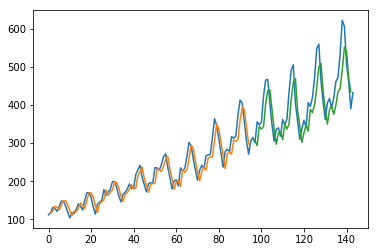

In [26]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()